<a href="https://colab.research.google.com/github/32173313/Machine-Learning-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)


True

# Data Import & Preprocessing

In [ ]:
from tensorflow.keras.datasets import imdb

# Load data
(X_train_seq, y_train), (X_test_seq, y_test) = imdb.load_data(num_words=20000)

# Decode sequences to text
word_index = imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '') for i in encoded_review])

train_texts = [decode_review(x) for x in X_train_seq]
test_texts  = [decode_review(x) for x in X_test_seq]


# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([w for w in text.split() if w not in stop_words])

# Apply preprocessing
train_clean = [remove_stopwords(clean_text(t)) for t in train_texts]
test_clean = [remove_stopwords(clean_text(t)) for t in test_texts]

print(f"Training samples: {len(train_clean)}")
print(f"Testing samples: {len(test_clean)}")
print(f"Positive/Negative split: {np.sum(y_train)}/{len(y_train)-np.sum(y_train)}")


Training samples: 25000
Testing samples: 25000
Positive/Negative split: 12500/12500


# Exploratory Data Analysis


Review length by sentiment:
             count       mean        std  min   25%   50%    75%     max
sentiment                                                               
0          25000.0  116.71152  84.218579  3.0  64.0  88.0  142.0   791.0
1          25000.0  118.17604  90.240366  6.0  62.0  87.0  145.0  1318.0

EDA visualization saved: eda_summary.png


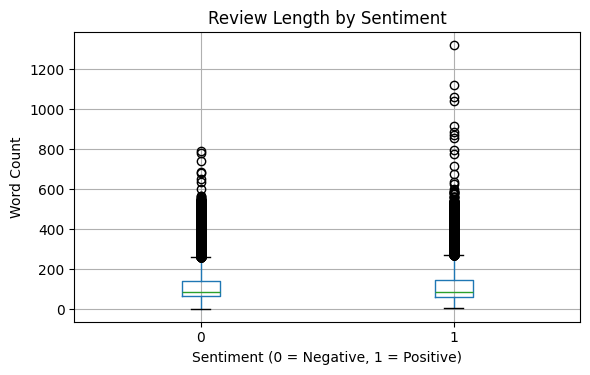

In [ ]:
df = pd.DataFrame({
    'review': train_clean + test_clean,
    'sentiment': np.concatenate([y_train, y_test])
})

df['length'] = df['review'].apply(lambda x: len(x.split()))

print("\nReview length by sentiment:")
print(df.groupby('sentiment')['length'].describe())

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

df.boxplot(column='length', by='sentiment', ax=ax)
ax.set_title('Review Length by Sentiment')
ax.set_xlabel('Sentiment (0 = Negative, 1 = Positive)')
ax.set_ylabel('Word Count')

plt.suptitle('')  # remove automatic title
plt.tight_layout()
plt.savefig('eda_summary.png', dpi=300)
print("\nEDA visualization saved: eda_summary.png")


# Feature Engineering

In [ ]:
# Method 1: TF-IDF Features
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(train_clean)
X_test_tfidf = tfidf.transform(test_clean)

print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape:  {X_test_tfidf.shape}")

# Method 2: Statistical Text Features

def extract_stat_features(texts):
    features = []
    for text in texts:
        words = text.split()
        features.append({
            'length': len(words),
            'unique_ratio': len(set(words)) / len(words) if words else 0,
            'avg_word_len': np.mean([len(w) for w in words]) if words else 0,
            'max_word_len': max([len(w) for w in words]) if words else 0,
        })
    return pd.DataFrame(features).values

X_train_stat = extract_stat_features(train_clean)
X_test_stat = extract_stat_features(test_clean)

print(f"Statistical features train shape: {X_train_stat.shape}")
print(f"Statistical features test shape:  {X_test_stat.shape}")

# Method 3: Word2Vec Embeddings
train_tokens = [text.split() for text in train_clean]

# Train Word2Vec on training data only
w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

def text_to_w2v(tokens, model, dim=100):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

X_train_w2v = np.array([text_to_w2v(t, w2v_model) for t in train_tokens])
X_test_w2v = np.array([
    text_to_w2v(text.split(), w2v_model) for text in test_clean
])

print(f"Word2Vec train shape: {X_train_w2v.shape}")
print(f"Word2Vec test shape:  {X_test_w2v.shape}")

# Combine All Features
X_train_combined = np.hstack([
    X_train_tfidf.toarray(),
    X_train_stat,
    X_train_w2v
])

X_test_combined = np.hstack([
    X_test_tfidf.toarray(),
    X_test_stat,
    X_test_w2v
])

print(f"Combined train shape: {X_train_combined.shape}")
print(f"Combined test shape:  {X_test_combined.shape}")


TF-IDF train shape: (25000, 3000)
TF-IDF test shape:  (25000, 3000)
Statistical features train shape: (25000, 4)
Statistical features test shape:  (25000, 4)
Word2Vec train shape: (25000, 100)
Word2Vec test shape:  (25000, 100)
Combined train shape: (25000, 3104)
Combined test shape:  (25000, 3104)


# Model Training

In [ ]:
results = {}

# Model 1: Logistic Regression (TF-IDF)
lr_tfidf = LogisticRegression(
    max_iter=2000,
    solver='liblinear',
    penalty='l2',
    C=2.0,
    class_weight='balanced',
    random_state=42
)

lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
y_prob_tfidf = lr_tfidf.predict_proba(X_test_tfidf)[:, 1]
acc_tfidf  = accuracy_score(y_test, y_pred_tfidf)
prec_tfidf = precision_score(y_test, y_pred_tfidf)
rec_tfidf  = recall_score(y_test, y_pred_tfidf)
f1_tfidf   = f1_score(y_test, y_pred_tfidf)
auc_tfidf  = roc_auc_score(y_test, y_prob_tfidf)

print(f"Accuracy : {acc_tfidf:.4f}")
print(f"Precision: {prec_tfidf:.4f}")
print(f"Recall   : {rec_tfidf:.4f}")
print(f"F1-score : {f1_tfidf:.4f}")
print(f"AUC      : {auc_tfidf:.4f}")


results['LogReg_TFIDF'] = {
    'accuracy': acc_tfidf,
    'precision': prec_tfidf,
    'recall': rec_tfidf,
    'f1': f1_tfidf,
    'auc': auc_tfidf,
    'y_pred': y_pred_tfidf,
    'y_prob': y_prob_tfidf
}

Accuracy : 0.8782
Precision: 0.8740
Recall   : 0.8839
F1-score : 0.8789
AUC      : 0.9510


In [ ]:
# Model 2: Random Forest (Combined features)
X_train_rf = np.hstack([X_train_stat, X_train_w2v])
X_test_rf  = np.hstack([X_test_stat, X_test_w2v])

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_rf, y_train)
y_pred_rf = rf_model.predict(X_test_rf)

y_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]
acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf)
auc_rf  = roc_auc_score(y_test, y_prob_rf)

print(f"Accuracy : {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall   : {rec_rf:.4f}")
print(f"F1-score : {f1_rf:.4f}")
print(f"AUC      : {auc_rf:.4f}")


results['RandomForest_Stat_W2V'] = {
    'accuracy': acc_rf,
    'precision': prec_rf,
    'recall': rec_rf,
    'f1': f1_rf,
    'auc': auc_rf,
    'y_pred': y_pred_rf,
    'y_prob': y_prob_rf
}

Accuracy : 0.8216
Precision: 0.8195
Recall   : 0.8248
F1-score : 0.8221
AUC      : 0.9020


In [ ]:
# Model 3: Neural Network (Word2Vec)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2

nn_model = Sequential([Dense(256, activation='relu', kernel_regularizer=l2(1e-4), input_shape=(100,)),
    BatchNormalization(), Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

nn_model.fit(
    X_train_w2v,
    y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_prob_nn = nn_model.predict(X_test_w2v).ravel()

y_pred_nn = (y_prob_nn >= 0.5).astype(int)

acc_nn  = accuracy_score(y_test, y_pred_nn)
prec_nn = precision_score(y_test, y_pred_nn)
rec_nn  = recall_score(y_test, y_pred_nn)
f1_nn   = f1_score(y_test, y_pred_nn)
auc_nn  = roc_auc_score(y_test, y_prob_nn)

print(f"Accuracy : {acc_nn:.4f}")
print(f"Precision: {prec_nn:.4f}")
print(f"Recall   : {rec_nn:.4f}")
print(f"F1-score : {f1_nn:.4f}")
print(f"AUC      : {auc_nn:.4f}")


results['NN_Word2Vec_Upgraded'] = {
    'accuracy': acc_nn,
    'precision': prec_nn,
    'recall': rec_nn,
    'f1': f1_nn,
    'auc': auc_nn,
    'y_pred': y_pred_nn,
    'y_prob': y_prob_nn
}


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7535 - auc: 0.8339 - loss: 0.5558 - precision: 0.7521 - recall: 0.7519 - val_accuracy: 0.8392 - val_auc: 0.9188 - val_loss: 0.4270 - val_precision: 0.8238 - val_recall: 0.8578
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8324 - auc: 0.9097 - loss: 0.4215 - precision: 0.8261 - recall: 0.8458 - val_accuracy: 0.8458 - val_auc: 0.9247 - val_loss: 0.3880 - val_precision: 0.8332 - val_recall: 0.8599
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8384 - auc: 0.9152 - loss: 0.4086 - precision: 0.8328 - recall: 0.8452 - val_accuracy: 0.8466 - val_auc: 0.9248 - val_loss: 0.3890 - val_precision: 0.8293 - val_recall: 0.8680
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8341 - auc: 0.9121 - loss: 0.4134 - precision: 0.8297 - recall: 0.8405 - val_accuracy: 0.8516 - val_auc: 0.9254 - val_loss: 0.3860 - val_precision: 0.8546 - val_recall: 0.8429
Epoch 5/15
313/313 ━━━━━━━━

In [ ]:
# Model 4: LSTM (Sequence data)
maxlen = 200

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad  = pad_sequences(X_test_seq, maxlen=maxlen)

y_train_lstm = y_train
y_test_lstm  = y_test
lstm_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=maxlen),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

lstm_model.fit(
    X_train_pad,
    y_train_lstm,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_prob_lstm = lstm_model.predict(X_test_pad).ravel()

y_pred_lstm = (y_prob_lstm >= 0.5).astype(int)

acc_lstm  = accuracy_score(y_test, y_pred_lstm)
prec_lstm = precision_score(y_test, y_pred_lstm)
rec_lstm  = recall_score(y_test, y_pred_lstm)
f1_lstm   = f1_score(y_test, y_pred_lstm)
auc_lstm  = roc_auc_score(y_test, y_prob_lstm)

print(f"Accuracy : {acc_lstm:.4f}")
print(f"Precision: {prec_lstm:.4f}")
print(f"Recall   : {rec_lstm:.4f}")
print(f"F1-score : {f1_lstm:.4f}")
print(f"AUC      : {auc_lstm:.4f}")

results['LSTM'] = {
    'accuracy': acc_lstm,
    'precision': prec_lstm,
    'recall': rec_lstm,
    'f1': f1_lstm,
    'auc': auc_lstm,
    'y_pred': y_pred_lstm,
    'y_prob': y_prob_lstm
}

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 453ms/step - accuracy: 0.6713 - auc: 0.7333 - loss: 0.5955 - val_accuracy: 0.8086 - val_auc: 0.8970 - val_loss: 0.4300
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 445ms/step - accuracy: 0.8622 - auc: 0.9273 - loss: 0.3428 - val_accuracy: 0.8294 - val_auc: 0.9076 - val_loss: 0.3911
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 383ms/step - accuracy: 0.9010 - auc: 0.9575 - loss: 0.2609 - val_accuracy: 0.8398 - val_auc: 0.9142 - val_loss: 0.3833
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 396ms/step - accuracy: 0.9237 - auc: 0.9730 - loss: 0.2051 - val_accuracy: 0.8452 - val_auc: 0.9204 - val_loss: 0.4018
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 362ms/step - accuracy: 0.9320 - auc: 0.9779 - loss: 0.1861 - val_accuracy: 0.8466 - val_auc: 0.9156 - val_loss: 0.4069
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step
Accuracy : 0.8371
Precision: 0.8599
Recall   : 0.8054
F1-score : 0.8318
AUC      : 0.9121


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-12-12 23:06:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-12 23:06:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-12 23:06:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
# Model 5: Transfer Learning（GloVe + LSTM）
# Load word index
vocab_size = 20000
word_index = imdb.get_word_index()

embedding_dim = 100
embedding_index = {}

with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

glove_lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix] ,
        input_length=maxlen,
        trainable=True
    ),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

glove_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

glove_lstm_model.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stop], verbose=1)

y_prob_glove = glove_lstm_model.predict(X_test_pad).ravel()

y_pred_glove = (y_prob_glove >= 0.5).astype(int)

acc_glove  = accuracy_score(y_test, y_pred_glove)
prec_glove = precision_score(y_test, y_pred_glove)
rec_glove  = recall_score(y_test, y_pred_glove)
f1_glove   = f1_score(y_test, y_pred_glove)
auc_glove  = roc_auc_score(y_test, y_prob_glove)

print(f"Accuracy : {acc_glove:.4f}")
print(f"Precision: {prec_glove:.4f}")
print(f"Recall   : {rec_glove:.4f}")
print(f"F1-score : {f1_glove:.4f}")
print(f"AUC      : {auc_glove:.4f}")

results['LSTM_GloVe'] = {
    'accuracy': acc_glove,
    'precision': prec_glove,
    'recall': rec_glove,
    'f1': f1_glove,
    'auc': auc_glove,
    'y_pred': y_pred_glove,
    'y_prob': y_prob_glove
}

Loaded 400000 word vectors from GloVe.
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 387ms/step - accuracy: 0.5278 - auc: 0.5413 - loss: 0.6929 - val_accuracy: 0.6838 - val_auc: 0.7570 - val_loss: 0.5955
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 374ms/step - accuracy: 0.6894 - auc: 0.7574 - loss: 0.5824 - val_accuracy: 0.8214 - val_auc: 0.9005 - val_loss: 0.4087
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 362ms/step - accuracy: 0.8263 - auc: 0.9055 - loss: 0.3915 - val_accuracy: 0.8598 - val_auc: 0.9326 - val_loss: 0.3456
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 373ms/step - accuracy: 0.8956 - auc: 0.9573 - loss: 0.2633 - val_accuracy: 0.8712 - val_auc: 0.9414 - val_loss: 0.3180
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 391ms/step - accuracy: 0.9260 - auc: 0.9769 - loss: 0.1928 - val_accuracy: 0.8764 - val_auc: 0.9436 - val_loss: 0.3603
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 361ms/step - accuracy: 0.9486 - auc: 0.9869 - loss: 0.1416 - val_accuracy: 0.8718 - val_auc: 0.9

# Results Analysis

Final Results Table:


,accuracy,precision,recall,f1,auc
LogReg_TFIDF,0.8782,0.8740,0.8839,0.8789,0.9510
LSTM_GloVe,0.8622,0.8703,0.8514,0.8607,0.9367
NN_Word2Vec_Upgraded,0.8488,0.8587,0.8349,0.8466,0.9273
LSTM,0.8371,0.8599,0.8054,0.8318,0.9121


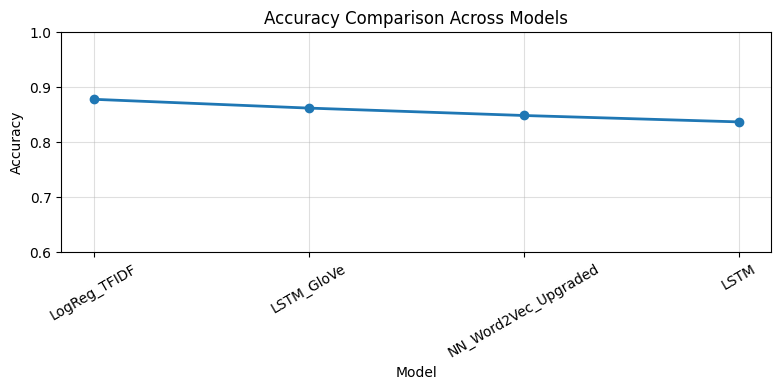

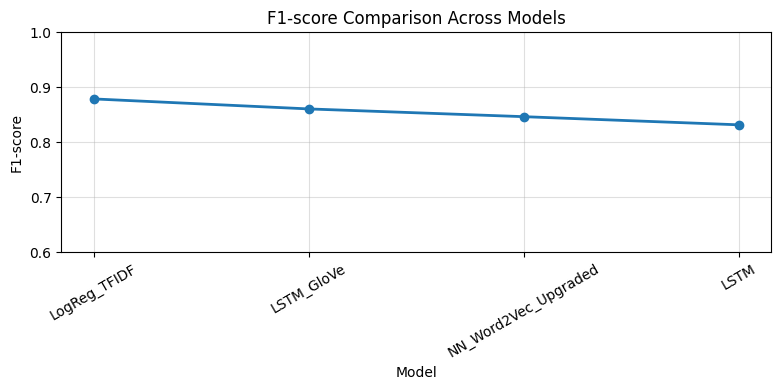

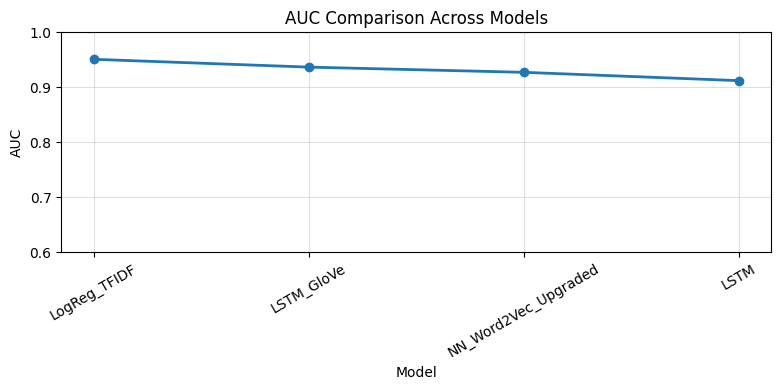

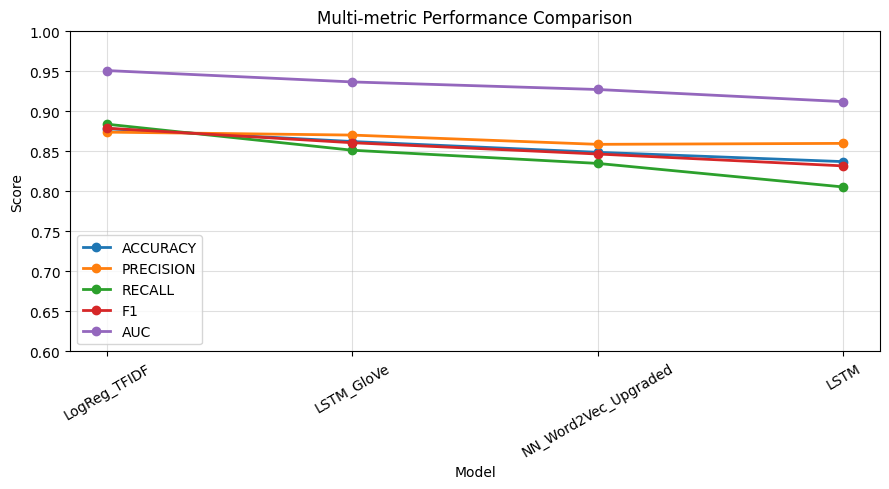

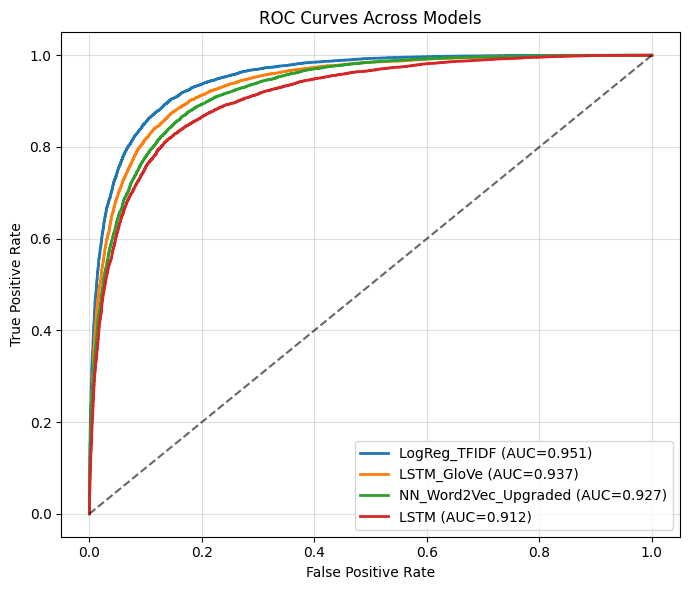

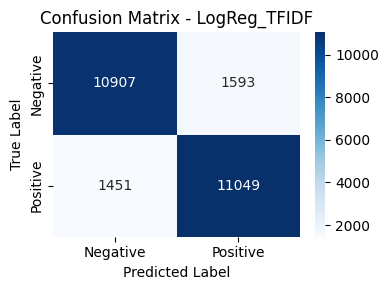

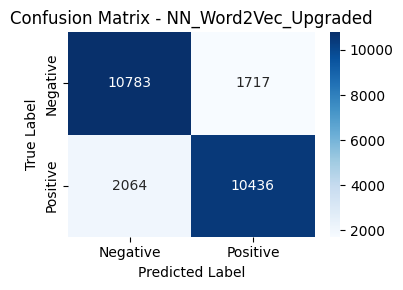

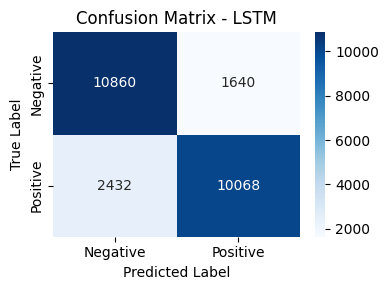

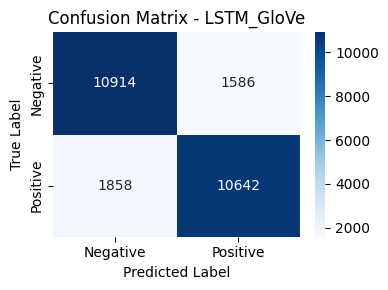

In [ ]:
from sklearn.metrics import roc_curve

results_df = pd.DataFrame.from_dict(results, orient='index')

results_df = results_df[
    ['accuracy', 'precision', 'recall', 'f1', 'auc']
]

results_df = results_df.sort_values(by='accuracy', ascending=False)

print("Final Results Table:")
display(results_df.round(4))

def plot_single_metric(metric, ylabel, title):
    plt.figure(figsize=(8, 4))
    plt.plot(
        results_df.index,
        results_df[metric],
        marker='o',
        linewidth=2
    )
    plt.ylabel(ylabel)
    plt.xlabel('Model')
    plt.title(title)
    plt.ylim(0.6, 1.0)
    plt.grid(alpha=0.4)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

plot_single_metric(
    metric='accuracy',
    ylabel='Accuracy',
    title='Accuracy Comparison Across Models'
)

plot_single_metric(
    metric='f1',
    ylabel='F1-score',
    title='F1-score Comparison Across Models'
)

plot_single_metric(
    metric='auc',
    ylabel='AUC',
    title='AUC Comparison Across Models'
)

plt.figure(figsize=(9, 5))

for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    plt.plot(
        results_df.index,
        results_df[metric],
        marker='o',
        linewidth=2,
        label=metric.upper()
    )

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Multi-metric Performance Comparison')
plt.ylim(0.6, 1.0)
plt.grid(alpha=0.4)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))

for model in results_df.index:
    fpr, tpr, _ = roc_curve(
        y_test,
        results[model]['y_prob']
    )
    plt.plot(
        fpr,
        tpr,
        linewidth=2,
        label=f"{model} (AUC={results_df.loc[model, 'auc']:.3f})"
    )

plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Across Models')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

model_names = results.keys()

for model_name in model_names:
    y_pred = results[model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive']
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()